In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from dal_toolbox.models.deterministic import DeterministicTrainer

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


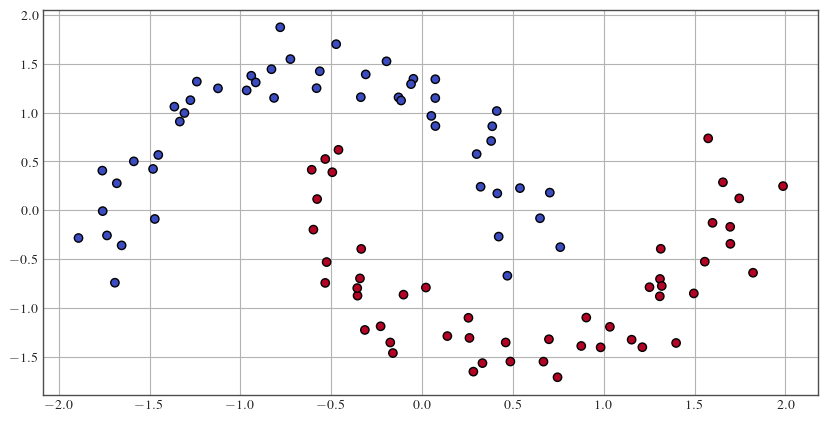

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self,
                 num_classes: int = 2,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [4]:
@torch.no_grad()
def plot_contour(model, domain=5, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [1] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.7032 (0.7032) acc1: 0.5000 (0.5000) time: 0.1642 data: 0.0013 max mem: 17
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.6230 (0.6230) acc1: 0.7000 (0.7000) time: 0.0021 data: 0.0006 max mem: 18
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.5243 (0.5243) acc1: 0.8700 (0.8700) time: 0.0022 data: 0.0006 max mem: 18
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.4377 (0.4377) acc1: 0.8600 (0.8600) time: 0.0026 data: 0.0008 max mem: 18
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.3852 (0.3852) acc1: 0.8400 (0.8400) time: 0.0026 data: 0.0009 max mem: 18
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.3479 (0.3479) acc1: 0.8600 (0.8600) time: 0.0026 data: 0.0010 max mem: 18
Epoch [6] Total time: 0:00:00
Epoch [7] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.3419 (0.3419) acc1: 0.8700 (0.8700) time

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


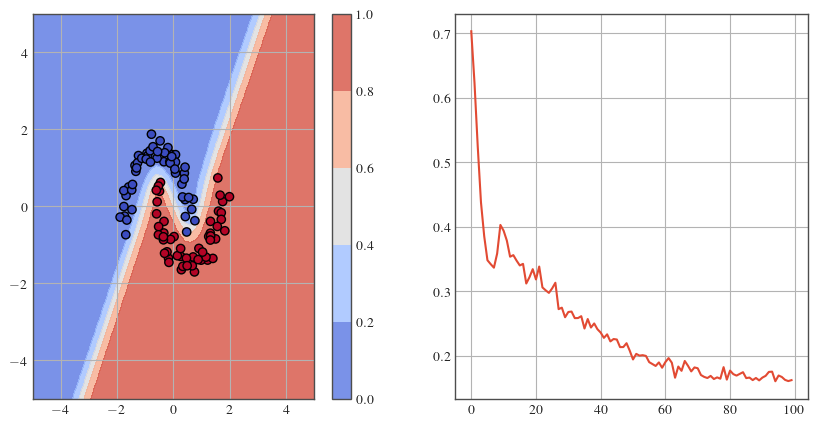

In [6]:
import lightning as L
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.utils.callbacks import MetricHistory
from dal_toolbox.metrics import BrierScore, Accuracy

num_epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=.9, weight_decay=.01)
trainer = DeterministicTrainer(
    model=model,
    criterion=nn.CrossEntropyLoss(label_smoothing=0.05),
    optimizer=optimizer,
    num_epochs=num_epochs,
)
history = trainer.fit(train_loader)

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_contour(model)
plt.subplot(122)
# plt.plot([h['train_loss'] for h in history['train_history']])
plt.plot([h['train_loss'] for h in history['train_history']])
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/Documents/projects/uncertainty_evaluation/dal_toolbox/models/deterministic/base.py:60: UserWarning: Using default optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01
).
  rank_zero_warn(f'Using default optimizer: {optimizer}.')

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Model            | 17.2 K
1 | metrics | ModuleDict       | 0     
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/py

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 171.76it/s, v_num=89, train_loss=0.0544, accuracy=0.990]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 122.32it/s, v_num=89, train_loss=0.0544, accuracy=0.990]


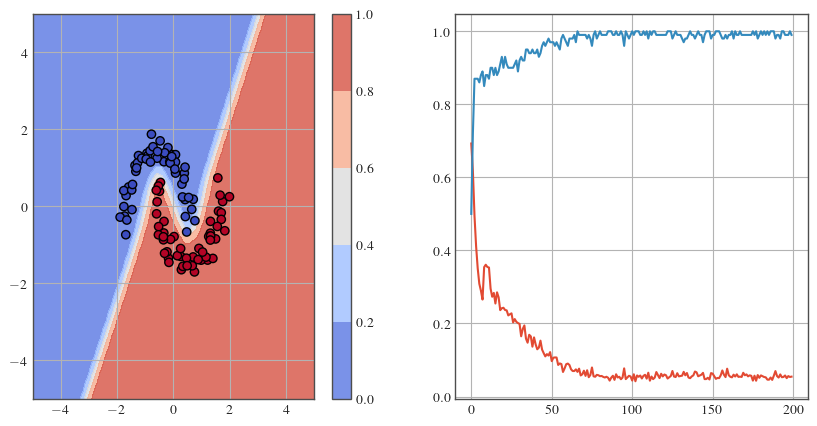

In [10]:
import copy
import lightning as L
from dal_toolbox.models.deterministic import DeterministicModel, DeterministicMixupModel, DeterministicLabelsmoothingModel
from dal_toolbox.models.utils.callbacks import MetricHistory
from dal_toolbox.metrics import BrierScore, Accuracy

num_epochs = 200
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = DeterministicModel(Model(), metrics={'accuracy': Accuracy()})
# model = DeterministicMixupModel(Model(), num_classes=2, mixup_alpha=0.1, metrics={'accuracy': Accuracy()} )
# model = DeterministicLabelsmoothingModel(Model(), label_smoothing=0.15, metrics={'accuracy': Accuracy()} )

history = MetricHistory()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_contour(model)
plt.subplot(122)
# plt.plot([h['train_loss'] for h in history['train_history']])
plt.plot([h['train_loss'] for h in history])
plt.plot([h['accuracy'] for h in history])
plt.show()